In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 18 17:20:28 2022

@author: WANG Haokun
@author: CHATROUX Marc
@author: LI Yuansheng
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from scipy import optimize
import tsp_gradient_outils as tsp

# Essayons de résoudre le TSP modélisé comme ci-dessous:
## Modèle des revues :
Soit les entrées suivantes :
$$ C\ :\ la\ matrice\ de\ coûts $$

min :
$$
trace_{H\ in\ T_n}(C^T*H)
$$


s.t.
$$ G_1(H) = ‖H − H ◦ H ‖^2_F = 0 $$
$$ G_2(H) = ‖ A · vec(H ) − B‖^2_2 = 0 $$

In [2]:
def get_m_a(size):
    """
    Génére la matrice A pour la contraite G_2
    """
    result = []

    # trace nul
    for i in range(size):
        new = [0] * size * size
        new[(size + 1) * i] = 1
        result += [new]
    # colonne == 2
    for i in range(size):
        new = [0] * size * size
        new[i * size:(i + 1) * size] = [1] * size
        result += [new]
    # ligne == 2
    for i in range(size):
        new = [0] * size
        new[i] = 1
        new = new * size
        result += [new]

    return np.array(result)

def get_m_b(size):
    """
    Génére la matrice B pour la contraite G_2
    """
    result = []

    # trace nul
    result += [[0]] * size
    # colonne == 2
    result += [[2]] * size
    # ligne == 2
    result += [[2]] * size

    return np.array(result)

def get_c(m_c):
    """
    Génére la matrice de coût pour la fonction de coût, avec une diagonale "forte"
    """
    result = m_c.copy()
    
    # NE PAS FAIRE CA !!! DONNE LES VALEURS NEGATIVE SUR LA DIAGONALE (EX : -0.24) SUREMENT POUR REDUIRE LE COUT

    # total = m_c.sum()    
    # for i in range(m_c.shape[0]):
    #     result[i, i] = total

    return result

def function_distance(x1, x2):
    """
    Retourne la distance (norme 2) entre deux vecteurs
    """
    vect = x1 - x2
    return np.sqrt(np.dot(vect, vect))

In [3]:
def the_big_solver(P_1, mute=False,
    n_iter = 100,
    Rho_var = 5e-1,
    Var_gamma_min = -10,
    Var_gamma_max = 1000,
    Var_gamma = 1,
    Epsilon_var = 1e-1,
    Epsilon_min = 1e-5,
    Theta_epsilon = 0.95,
    Theta_rho = 0.95,
    Theta_sigma = 0.99,
    D_min = 1e-3):
    """
    Réalise une simualtion avec les paramètres suivants :
        - n_iter : nombre d'itération maximal
        - Rho_var : Coefficient de pénalité initial
        - Var_gamma_min : Borne supérieur des coefficients de contraintes d'égalité
        - Var_gamma_max : Borne inférieur des coefficients de contraintes d'égalité
        - Var_gamma : Valeur initiales des coefficients de contraintes d'égalité
        - Epsilon_var : Valeur initiale de la précision
        - Epsilon_min : Valeur minimale de la précision
        - Theta_epsilon : Ratio pour l'évolution de Epsilon
        - Theta_rho : Ratio pour l'évolution de Rho
        - Theta_sigma : Ratio pour les critères d'évolution de Rho
        - D_min : Valeur du pas minimal
    
    On travail avec une forme vectoriel (dimension 1)
    """

    def function_f(vec_x):
        """
        Fonction de cout classique
        """
        n = np.int64(np.sqrt(vec_x.shape[0]))
        x = vec_x.reshape((n, n))
        return tsp.trace(C.T @ x)

    def function_h(vec_x):
        """
        Fonction de cout des contraintes d'égalités
        """        
        n = np.int64(np.sqrt(vec_x.shape[0]))
        x = vec_x.reshape((n, n))
        
        result = []

        # Contrainte de trace, la somme des ligne et la somme des colonne
        temp_vec = (M_a @ vec_x.reshape((n *n, 1)) - M_b).flatten()
        result += [[np.dot(temp_vec, temp_vec)]]
        # temp_vec = (M_a @ vec_x.reshape((n *n, 1)) - M_b)
        # result += [[np.linalg.norm(temp_vec, ord=2)**2]]

        # égalité : 0 = || H - H ° H ||_frov
        result += [[np.sum(np.square(np.abs(x - tsp.indiv_product(x, x))))]]

        return np.array(result)

    def function_global_cost(vec_x, gamma_value, rho_value):
        """
        Fonction de cout global
        """
        return function_f(vec_x) + rho_value / 2 * np.sum(np.square(function_h(vec_x) + gamma_value / rho_value))

    def function_eval(vec_x):
        """
        Evalue le respect des contraintes
        """
        return np.sum(function_h(vec_x))
    
    n_iter = np.int64(n_iter)

    # CONSTANTES
    n_size = P_1.get_number()
    C = get_c(P_1.get_cost_array())
    M_a = get_m_a(n_size)
    M_b = get_m_b(n_size)

    # VECTEUR INITIALE
    X_var = tsp.matrix_undir(n_size)
    # X_var[0, 1] = 0.8
    X_var = X_var.flatten()

    # INITIALISATION DES GAMMAS
    SIZE_GAMMA = len(function_h(X_var))
    Gamma_var = np.ones((SIZE_GAMMA, 1)) * Var_gamma
    Gamma_min = np.ones((SIZE_GAMMA, 1)) * Var_gamma_min
    Gamma_max = np.ones((SIZE_GAMMA, 1)) * Var_gamma_max

    # STOCKAGE DE VALEURS
    X_list, Gamma_list, Epsilon_list, Rho_list, H_list, D_list = [], [], [], [], [], []
    Cost_list, Global_cost_list, Eval_list = [], [], []
    X_list += [X_var]
    Gamma_list += [Gamma_var]
    Epsilon_list += [np.array([[Epsilon_var]])]
    Rho_list += [Rho_var]
    Cost_list += [function_f(X_var)]
    Global_cost_list += [function_global_cost(X_var, Gamma_var, Rho_var)]
    Eval_list += [function_eval(X_var)]
    H_list += [function_h(X_var)]

    # afficha (ou non) la barre de chargement
    iter_object = range(n_iter) if mute else tqdm(range(n_iter))

    # itération...
    for k in iter_object:

        # SAUVEGARDE TEMPORAIRE POUR CALCULS
        X_var = X_var.copy()
        Gamma_var = Gamma_var.copy()
        X_var_old = X_var.copy()

        # CALCUL DU NOUVEAU X
        function_to_solve = lambda X :  function_global_cost(X, Gamma_var, Rho_var)
        X_var = optimize.minimize(function_to_solve, X_var, tol=Epsilon_var).x
        distance = function_distance(X_var, X_var_old)

        # MODIF DES PARAMETRES DU RALM
        Gamma_var = np.clip(Gamma_var + Rho_var * function_h(X_var), Gamma_min, Gamma_max)
        Epsilon_var = max(Epsilon_min, Theta_epsilon * Epsilon_var)

        max_1 = function_h(X_var).max()
        max_2 = function_h(X_var_old).max()
        if k == 0 or max_1 <= Theta_sigma * max_2:
            Rho_var = Rho_var
        else:
            Rho_var = Theta_rho * Rho_var


        # STOCKAGE DE VALEURS
        X_list += [X_var]
        Gamma_list += [Gamma_var]
        Epsilon_list += [np.array([[Epsilon_var]])]
        Rho_list += [Rho_var]
        Cost_list += [function_f(X_var)]
        Global_cost_list += [function_global_cost(X_var, Gamma_var, Rho_var)]
        Eval_list += [function_eval(X_var)]
        H_list += [function_h(X_var)]
        D_list +=  [distance]

        # ARRET DE BOUCLE
        if distance <= D_min and Epsilon_var <= Epsilon_min:
            break

    # reshape vers carré pour analyse du résultat
    n = np.int64(np.sqrt(X_var.shape[0]))
    X_var = X_var.reshape((n, n))

    # INDICATEUR
    M_delta = P_1.lp_solution + P_1.lp_solution.T - np.round(X_var)
    Nb_delta = np.sum(M_delta != 0)
    Sm_delta = np.sum(np.abs(M_delta))
    Cost_result = function_f(np.round(X_var).flatten())
    True_cost_result = function_f(X_var.flatten())
    Cost_best = function_f((P_1.lp_solution + P_1.lp_solution.T).flatten())

    if not mute:
        # AFFICHAGE DU BILAN
        print(f"##### FIN !!! / DISTANCE = {distance} / EPSILON = {Epsilon_var} ###")

        # TOUT LES GRAPHES, OU LA MATRICE X SEUL
        ############################################################################################################################################
        ###                IL FAUT COMMENTER / DECOMMENTER UNE DES LIGNES SUIVANTES POUR NE PAS AFFICHER TOUS LES GRAPHES                        ###
        ###                le paramètre ungroup permet de regrouper les graphes sur une seule fenêtre si besoin                                  ###
        ############################################################################################################################################
        # tsp.plot_array([X_list, H_list, Gamma_list, Epsilon_list, Rho_list, Cost_list, Global_cost_list, Eval_list, D_list], ["X_list", "H_list",  "Gamma_list", "Epsilon_list", "Rho_list", "Cost", "Global cost", "Eval", "D_list"], ungroup=True)
        tsp.plot_array([X_list], ["X_list"], ungroup=True)

        print(" - Nombre de différence :", Nb_delta)
        print(" - Somme des différence :", Sm_delta)
        print(" - Différence de fonction objective :", np.round((Cost_result - Cost_best) / Cost_best * 10000) / 100, "%")
        print("Fonction f :", True_cost_result)
        print("Fonction f (arrondi) :", Cost_result)
        print("Excepted value : ", Cost_best)

        print("X :", np.round(X_var * 100) / 100)
        print("DELTA :", np.round(X_var) - P_1.lp_solution - P_1.lp_solution.T)
        
        print("Fonction h :", function_h(X_var.flatten()))
        print("Gamma :", Gamma_var)
        print("Rho :", Rho_var)
        print("Fonction L :", function_global_cost(X_var.flatten(), Gamma_var, Rho_var))

    return Nb_delta, Sm_delta, Cost_result, Cost_best, len(X_list), tsp.norm_fro(X_var - P_1.lp_solution + P_1.lp_solution.T)

# Réalisation de statistique :

In [4]:
def a_run(size=4, ratio=1, mute_stat=False, mute_opt=True, rounded=True, mute_run=False, **kargs):
    """
    Pour évaluer les écarts sur {ratio} % du dossier de taille {size}
    On peux rendre muet des parties :
        - mute_stat : les statistiques du résultat 
        - mute_opt : les informations de la fonction d'optimisation (graphiques, progression, et bilan)
        - mute_run : la barre de progression de cette fonction
    On peux passer des valeurs de simulation en paramètre (Epsilon_var, etc.)
    Le résultat prend en compte l'arrondi de la matrice final (rounded=True), ou la norme (fro) entre la matrice résultat et la matrice optinal
    """
    list_result = []

    the_path = f"data/size_{size:03d}/"
    list_of_file = sorted(os.listdir(the_path))
    nb_of_file = len(list_of_file)

    goal_rank = int(ratio / 100 * nb_of_file)

    P_1 = tsp.TSPProblem(6, 10)
    the_iterator = list_of_file[0:goal_rank] if mute_run else tqdm(list_of_file[0:goal_rank])

    for file_name in the_iterator:
        P_1.load(the_path + file_name)
        result_opt = the_big_solver(P_1, mute=mute_opt, **kargs)
        list_result += [abs(result_opt[3] - result_opt[2]) / result_opt[3] * 100 if rounded else result_opt[5]]

    if not mute_stat:
        print("  - Mean :", np.mean(list_result), "%")
        print("  - Std :", np.std(list_result), "%")
        print("  - Min :", np.min(list_result), "%")
        print("  - Max :", np.max(list_result), "%")
        print("  - List :", list_result)

    return np.mean(list_result)

# Simulation :

In [5]:
# On peux importer un fichier seul, afin de réaliser une résolution
# On peux même ne pas importer de fichiers, mais cela nécessite qu'un solveur (PULP et GUROBI) soit installé

P_1 = tsp.TSPProblem(6, 10)
# P_1.save("test.csv")
P_1.load("test.csv")

# P_1 = tsp.TSPProblem(8, 10)
# P_1.load("test_size_8.csv")

_ = P_1.lp_solve()

100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


##### FIN !!! / DISTANCE = 0.0006946858784752649 / EPSILON = 0.0005920529220333994 ###


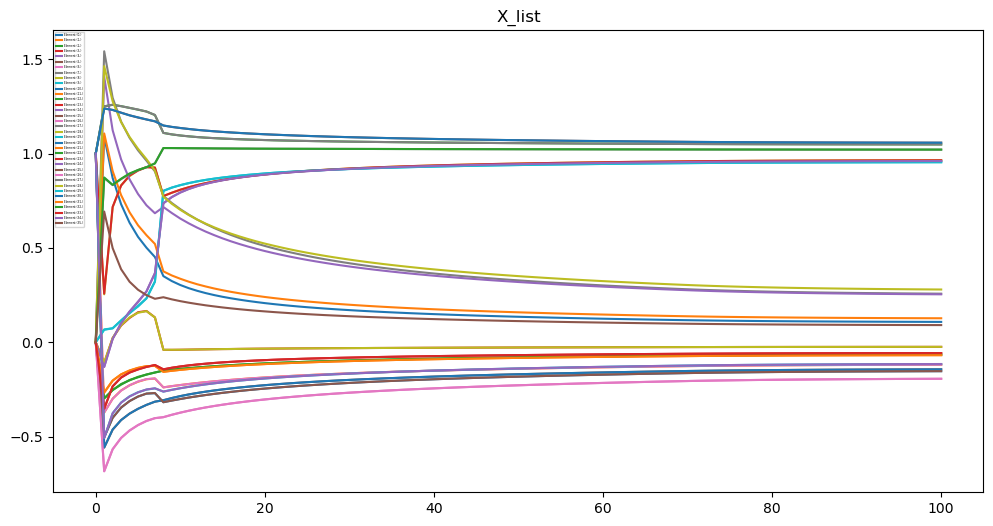

 - Nombre de différence : 0
 - Somme des différence : 0.0
 - Différence de fonction objective : 0.0 %
Fonction f : 277.7845334300051
Fonction f (arrondi) : 386.3661946462156
Excepted value :  386.3661946462156
X : [[ 0.11 -0.12 -0.07 -0.02  0.96  1.06]
 [-0.12  0.26  0.96  0.95 -0.15 -0.07]
 [-0.07  0.96  0.25 -0.14 -0.19  1.02]
 [-0.02  0.95 -0.14  0.13  1.05 -0.06]
 [ 0.96 -0.15 -0.19  1.05  0.28 -0.12]
 [ 1.06 -0.07  1.02 -0.06 -0.12  0.09]]
DELTA : [[ 0. -0. -0. -0.  0.  0.]
 [-0.  0.  0.  0. -0. -0.]
 [-0.  0.  0. -0. -0.  0.]
 [-0.  0. -0.  0.  0. -0.]
 [ 0. -0. -0.  0.  0. -0.]
 [ 0. -0.  0. -0. -0.  0.]]
Fonction h : [[0.45579379]
 [0.48414522]]
Gamma : [[65.41173012]
 [50.8450982 ]]
Rho : 0.10195341287289517
Fonction L : 33994.271483360535
Sans param (6) (0, 0.0, 386.3661946462156, 386.3661946462156, 101, 4.952655259411238)


 90%|████████▉ | 179/200 [00:44<00:05,  4.07it/s]


##### FIN !!! / DISTANCE = 5.986209851937283e-05 / EPSILON = 1e-05 ###


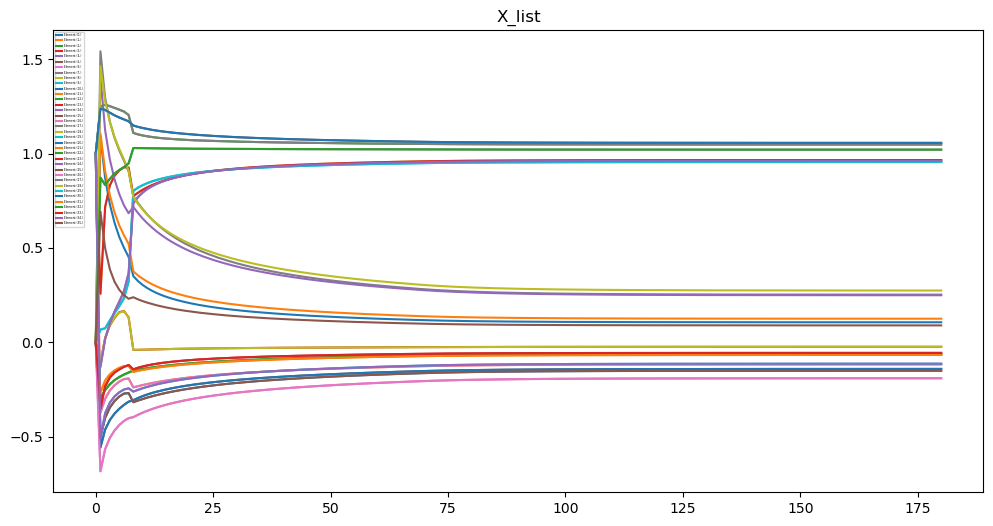

 - Nombre de différence : 0
 - Somme des différence : 0.0
 - Différence de fonction objective : 0.0 %
Fonction f : 279.5286287135486
Fonction f (arrondi) : 386.3661946462156
Excepted value :  386.3661946462156
X : [[ 0.11 -0.12 -0.06 -0.02  0.96  1.06]
 [-0.12  0.25  0.97  0.96 -0.15 -0.07]
 [-0.06  0.97  0.25 -0.14 -0.19  1.02]
 [-0.02  0.96 -0.14  0.12  1.05 -0.06]
 [ 0.96 -0.15 -0.19  1.05  0.27 -0.11]
 [ 1.06 -0.07  1.02 -0.06 -0.11  0.09]]
DELTA : [[ 0. -0. -0. -0.  0.  0.]
 [-0.  0.  0.  0. -0. -0.]
 [-0.  0.  0. -0. -0.  0.]
 [-0.  0. -0.  0.  0. -0.]
 [ 0. -0. -0.  0.  0. -0.]
 [ 0. -0.  0. -0. -0.  0.]]
Fonction h : [[0.44108155]
 [0.46903875]]
Gamma : [[66.31036747]
 [51.80020375]]
Rho : 0.0016837987834257264
Fonction L : 2102818.8373601865
Sans param (6) (0, 0.0, 386.3661946462156, 386.3661946462156, 181, 4.951553784366157)


 90%|████████▉ | 179/200 [00:10<00:01, 16.31it/s]


##### FIN !!! / DISTANCE = 0.0 / EPSILON = 1e-05 ###


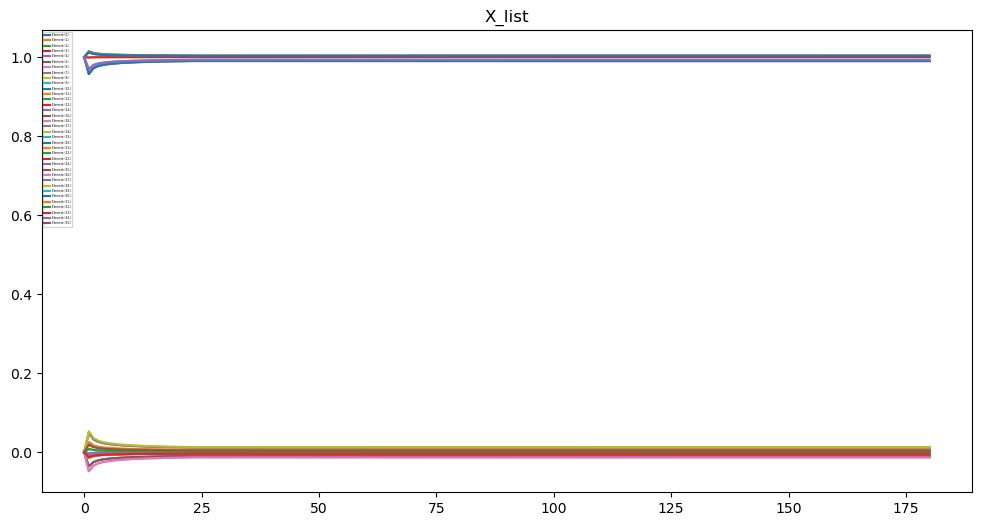

 - Nombre de différence : 12
 - Somme des différence : 12.0
 - Différence de fonction objective : 25.32 %
Fonction f : 477.7711238553053
Fonction f (arrondi) : 484.1807303879296
Excepted value :  386.3661946462156
X : [[ 0.01  0.99 -0.   -0.   -0.    1.  ]
 [ 0.99  0.01  1.   -0.   -0.01 -0.  ]
 [-0.    1.    0.01  0.99 -0.01  0.  ]
 [-0.   -0.    0.99  0.01  1.   -0.  ]
 [-0.   -0.01 -0.01  1.    0.01  0.99]
 [ 1.   -0.    0.   -0.    0.99  0.  ]]
DELTA : [[ 0.  1. -0. -0. -1.  0.]
 [ 1.  0.  0. -1. -0. -0.]
 [-0.  0.  0.  1. -0. -1.]
 [-0. -1.  1.  0.  0. -0.]
 [-1. -0. -0.  0.  0.  1.]
 [ 0. -0. -1. -0.  1.  0.]]
Fonction h : [[0.00157781]
 [0.00162983]]
Gamma : [[1000.]
 [1000.]]
Rho : 3.1813102910297433
Fonction L : 314816.8682290033
Avec param (6) (12, 12.0, 484.1807303879296, 386.3661946462156, 181, 4.891875795936724)


 90%|████████▉ | 179/200 [00:14<00:01, 12.00it/s]


##### FIN !!! / DISTANCE = 2.7211984398158374e-06 / EPSILON = 1e-05 ###


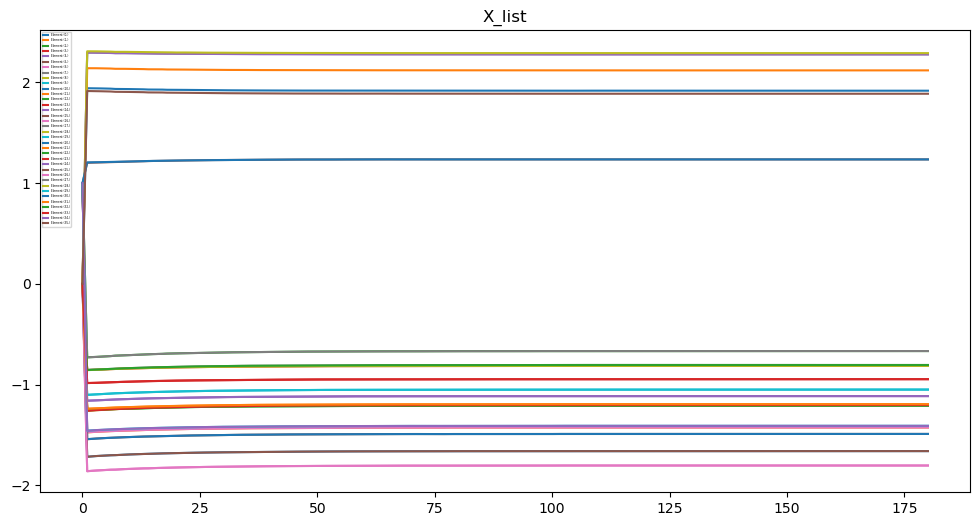

 - Nombre de différence : 34
 - Somme des différence : 54.0
 - Différence de fonction objective : -484.48 %
Fonction f : -1559.1238638294788
Fonction f (arrondi) : -1485.5054667303316
Excepted value :  386.3661946462156
X : [[ 1.92 -1.43 -1.21 -0.81 -1.11  1.24]
 [-1.43  2.28 -1.2  -1.05 -1.66 -1.2 ]
 [-1.21 -1.2   2.28 -1.49 -1.8  -0.81]
 [-0.82 -1.05 -1.49  2.12 -0.67 -0.95]
 [-1.12 -1.66 -1.8  -0.67  2.29 -1.41]
 [ 1.24 -1.2  -0.81 -0.95 -1.41  1.89]]
DELTA : [[ 2. -1. -1. -1. -2.  0.]
 [-1.  2. -2. -2. -2. -1.]
 [-1. -2.  2. -1. -2. -2.]
 [-1. -2. -1.  2. -2. -1.]
 [-2. -2. -2. -2.  2. -1.]
 [ 0. -1. -2. -1. -1.  2.]]
Fonction h : [[355.89829714]
 [282.80652156]]
Gamma : [[1.07773901]
 [1.0626689 ]]
Rho : 1.0292605961181952e-09
Fonction L : 1112830300.179607
Avec param (6) (34, 54.0, -1485.5054667303316, 386.3661946462156, 181, 9.253673204566288)


In [6]:
# On peux alors le solver avec les paramètres par défaut
print("Sans param (6)", the_big_solver(P_1))

# On peux aussi modifier les paramètres suivants
# - n_iter : nombre d'itération maximal
# - Rho_var : Coefficient de pénalité initial
# - Var_gamma_min : Borne supérieur des coefficients de contraintes d'égalité
# - Var_gamma_max : Borne inférieur des coefficients de contraintes d'égalité
# - Var_gamma : Valeur initiales des coefficients de contraintes d'égalité
# - Epsilon_var : Valeur initiale de la précision
# - Epsilon_min : Valeur minimale de la précision
# - Theta_epsilon : Ratio pour l'évolution de Epsilon
# - Theta_rho : Ratio pour l'évolution de Rho
# - Theta_sigma : Ratio pour les critères d'évolution de Rho
# - D_min : Valeur du pas minimal

# EX :
print("Sans param (6)", the_big_solver(P_1, n_iter=200))

# EX : Pondération forte sur les contraintes
print("Avec param (6)", the_big_solver(P_1, n_iter=200, Rho_var=10000))
# On ne varie pas pour ne pas s'éloigner de la contrainte

# EX : Pondération faible sur les contraintes
print("Avec param (6)", the_big_solver(P_1, n_iter=200, Rho_var=0.00001))
# On varie s'en se soucier de la contrainte

100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


##### FIN !!! / DISTANCE = 0.00034529648219744737 / EPSILON = 0.0005920529220333994 ###


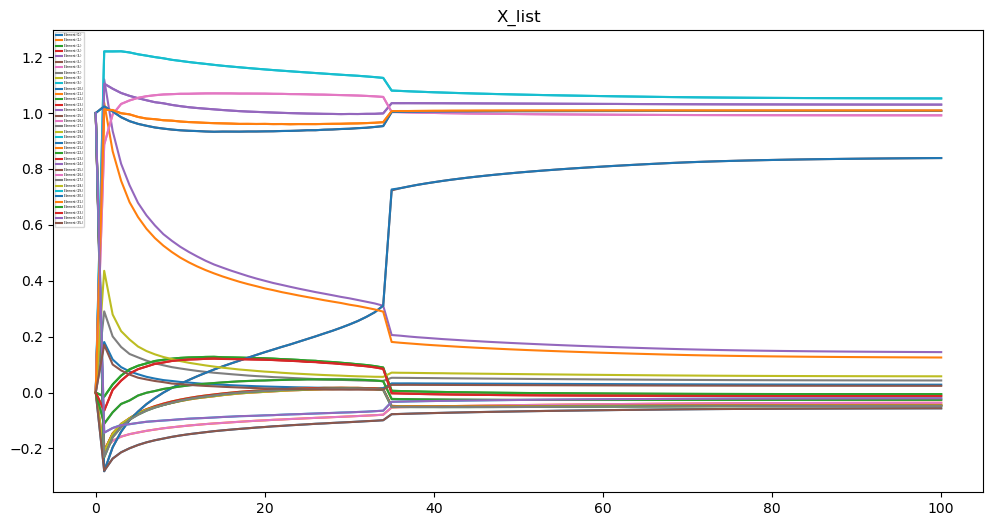

100%|██████████| 1/1 [00:17<00:00, 17.99s/it]


 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : 1.97 %
Fonction f : 38.733729148996346
Fonction f (arrondi) : 44.15628502508495
Excepted value :  43.30372961038708
X : [[ 0.03 -0.04 -0.01 -0.05  1.03  1.01]
 [-0.04  0.04 -0.05  1.05 -0.06  1.01]
 [-0.01 -0.05  0.14  0.84  0.99 -0.03]
 [-0.05  1.05  0.84  0.13 -0.05 -0.01]
 [ 1.03 -0.06  0.99 -0.05  0.06 -0.02]
 [ 1.01  1.01 -0.03 -0.01 -0.02  0.02]]
DELTA : [[ 0. -0. -0. -0.  0.  0.]
 [-0.  0. -1.  0. -0.  1.]
 [-0. -1.  0.  1.  0. -0.]
 [-0.  0.  1.  0. -0. -1.]
 [ 0. -0.  0. -0.  0. -0.]
 [ 0.  1. -0. -1. -0.  0.]]
Fonction h : [[0.08860576]
 [0.1050738 ]]
Gamma : [[17.76456578]
 [11.97412111]]
Rho : 0.09201295511778788
Fonction L : 2535.5600346634633
  - Mean : 1.9687805700998304 %
  - Std : 0.0 %
  - Min : 1.9687805700998304 %
  - Max : 1.9687805700998304 %
  - List : [1.9687805700998304]
1.9687805700998304


100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


##### FIN !!! / DISTANCE = 0.00034529648219744737 / EPSILON = 0.0005920529220333994 ###


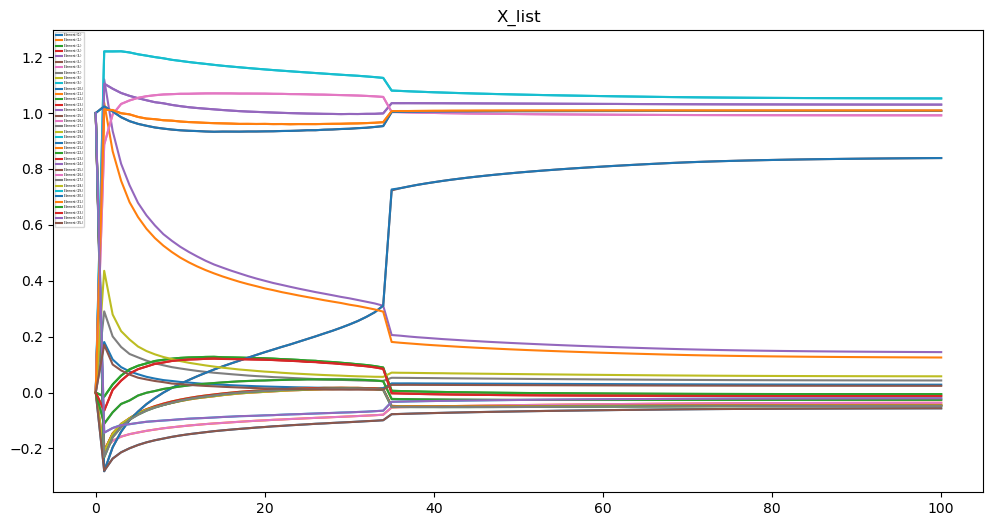

 10%|█         | 1/10 [00:13<02:03, 13.72s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : 1.97 %
Fonction f : 38.733729148996346
Fonction f (arrondi) : 44.15628502508495
Excepted value :  43.30372961038708
X : [[ 0.03 -0.04 -0.01 -0.05  1.03  1.01]
 [-0.04  0.04 -0.05  1.05 -0.06  1.01]
 [-0.01 -0.05  0.14  0.84  0.99 -0.03]
 [-0.05  1.05  0.84  0.13 -0.05 -0.01]
 [ 1.03 -0.06  0.99 -0.05  0.06 -0.02]
 [ 1.01  1.01 -0.03 -0.01 -0.02  0.02]]
DELTA : [[ 0. -0. -0. -0.  0.  0.]
 [-0.  0. -1.  0. -0.  1.]
 [-0. -1.  0.  1.  0. -0.]
 [-0.  0.  1.  0. -0. -1.]
 [ 0. -0.  0. -0.  0. -0.]
 [ 0.  1. -0. -1. -0.  0.]]
Fonction h : [[0.08860576]
 [0.1050738 ]]
Gamma : [[17.76456578]
 [11.97412111]]
Rho : 0.09201295511778788
Fonction L : 2535.5600346634633


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


##### FIN !!! / DISTANCE = 0.00033323874265951713 / EPSILON = 0.0005920529220333994 ###


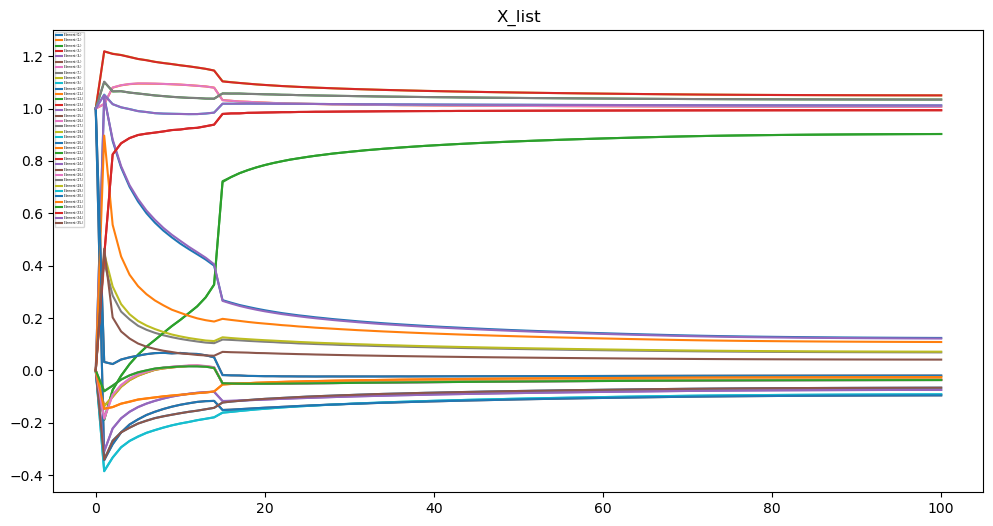

 20%|██        | 2/10 [00:26<01:45, 13.13s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -0.28 %
Fonction f : 53.12202803021385
Fonction f (arrondi) : 62.028801819653566
Excepted value :  62.2050522125665
X : [[ 0.12  1.01  0.9  -0.03 -0.07 -0.02]
 [ 1.01  0.07  1.05 -0.09 -0.07 -0.03]
 [ 0.9   1.05  0.12 -0.1  -0.04 -0.04]
 [-0.03 -0.09 -0.1   0.11  1.03  0.99]
 [-0.07 -0.07 -0.04  1.03  0.07  1.01]
 [-0.02 -0.03 -0.04  0.99  1.01  0.04]]
DELTA : [[ 0.  0.  1. -1. -0. -0.]
 [ 0.  0.  0. -0. -0. -0.]
 [ 1.  0.  0. -0. -0. -1.]
 [-1. -0. -0.  0.  0.  1.]
 [-0. -0. -0.  0.  0.  0.]
 [-0. -0. -1.  1.  0.  0.]]
Fonction h : [[0.12007434]
 [0.14162415]]
Gamma : [[18.86046224]
 [15.56283336]]
Rho : 0.0968557422292504
Fonction L : 3144.2386323357377


100%|██████████| 100/100 [00:11<00:00,  9.08it/s]


##### FIN !!! / DISTANCE = 0.0003086860965169981 / EPSILON = 0.0005920529220333994 ###


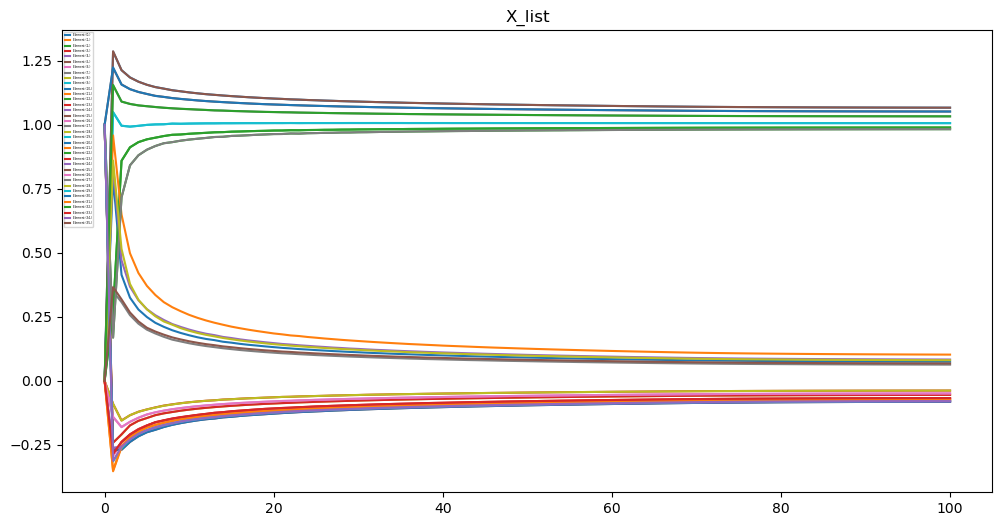

 30%|███       | 3/10 [00:38<01:27, 12.44s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -10.71 %
Fonction f : 32.38836517449893
Fonction f (arrondi) : 40.4523512354909
Excepted value :  45.302933761996194
X : [[ 0.07 -0.07  0.99 -0.04 -0.08  1.05]
 [-0.07  0.06 -0.05  1.01  1.07 -0.07]
 [ 0.99 -0.05  0.08 -0.08 -0.05  1.03]
 [-0.04  1.01 -0.08  0.1   0.98 -0.07]
 [-0.08  1.07 -0.05  0.98  0.08 -0.08]
 [ 1.05 -0.07  1.03 -0.07 -0.08  0.07]]
DELTA : [[ 0. -0.  1. -1. -0.  0.]
 [-0.  0. -0.  0.  0. -0.]
 [ 1. -0.  0. -0. -1.  0.]
 [-1.  0. -0.  0.  1. -0.]
 [-0.  0. -1.  1.  0. -0.]
 [ 0. -0.  0. -0. -0.  0.]]
Fonction h : [[0.10793442]
 [0.14582498]]
Gamma : [[14.07583352]
 [16.72614754]]
Rho : 0.09201295511778788
Fonction L : 2633.2276661544925


100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


##### FIN !!! / DISTANCE = 0.0002787990293001533 / EPSILON = 0.0005920529220333994 ###


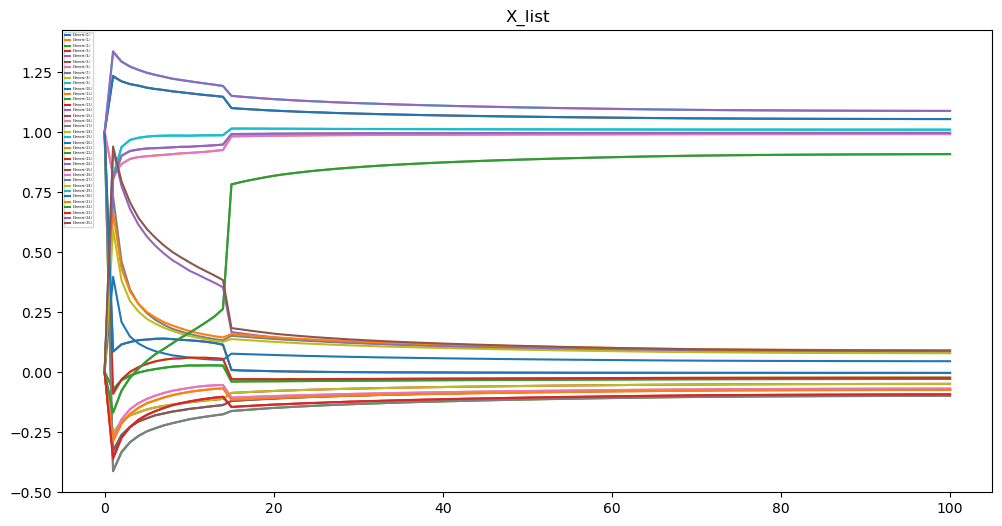

 40%|████      | 4/10 [00:52<01:18, 13.04s/it]

 - Nombre de différence : 0
 - Somme des différence : 0.0
 - Différence de fonction objective : 0.0 %
Fonction f : 38.64281234040169
Fonction f (arrondi) : 47.678905607466994
Excepted value :  47.678905607466994
X : [[ 0.05  0.99 -0.03 -0.05  1.   -0.  ]
 [ 0.99  0.09 -0.02  1.01 -0.07 -0.07]
 [-0.03 -0.02  0.08  1.06 -0.07  0.91]
 [-0.05  1.01  1.06  0.09 -0.1  -0.09]
 [ 1.   -0.07 -0.07 -0.1   0.08  1.09]
 [-0.   -0.07  0.91 -0.09  1.09  0.09]]
DELTA : [[ 0.  0. -0. -0.  0. -0.]
 [ 0.  0. -0.  0. -0. -0.]
 [-0. -0.  0.  0. -0.  0.]
 [-0.  0.  0.  0. -0. -0.]
 [ 0. -0. -0. -0.  0.  0.]
 [-0. -0.  0. -0.  0.  0.]]
Fonction h : [[0.10367035]
 [0.15922497]]
Gamma : [[15.98838269]
 [17.51678767]]
Rho : 0.07888960739411338
Fonction L : 3607.9852164952454


100%|██████████| 100/100 [00:12<00:00,  7.75it/s]


##### FIN !!! / DISTANCE = 0.00032572294645136175 / EPSILON = 0.0005920529220333994 ###


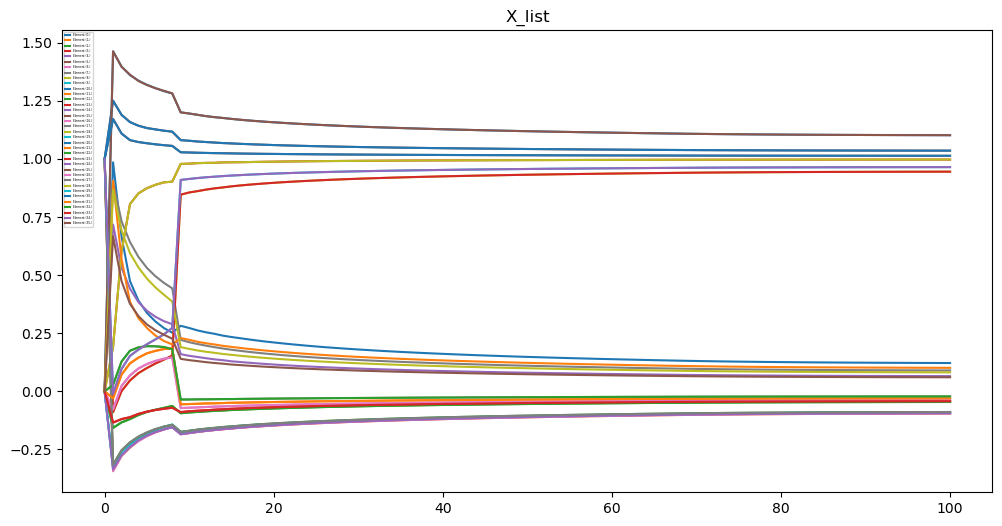

 50%|█████     | 5/10 [01:05<01:06, 13.20s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : 0.12 %
Fonction f : 47.72865904483649
Fonction f (arrondi) : 59.05264071476323
Excepted value :  58.98436016441066
X : [[ 0.12 -0.1  -0.05  1.   -0.09  1.01]
 [-0.1   0.09  0.95 -0.09  1.1  -0.03]
 [-0.05  0.95  0.07  1.04 -0.04 -0.02]
 [ 1.   -0.09  1.04  0.1  -0.09 -0.04]
 [-0.09  1.1  -0.04 -0.09  0.08  0.96]
 [ 1.01 -0.03 -0.02 -0.04  0.96  0.06]]
DELTA : [[ 0. -0. -0.  0. -0.  0.]
 [-0.  0.  1. -0.  0. -1.]
 [-0.  1.  0.  0. -1. -0.]
 [ 0. -0.  0.  0. -0. -0.]
 [-0.  0. -1. -0.  0.  1.]
 [ 0. -1. -0. -0.  1.  0.]]
Fonction h : [[0.12274885]
 [0.17194377]]
Gamma : [[18.13653165]
 [19.3642059 ]]
Rho : 0.0968557422292504
Fonction L : 3687.0734912443113


100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


##### FIN !!! / DISTANCE = 0.00030614816746171443 / EPSILON = 0.0005920529220333994 ###


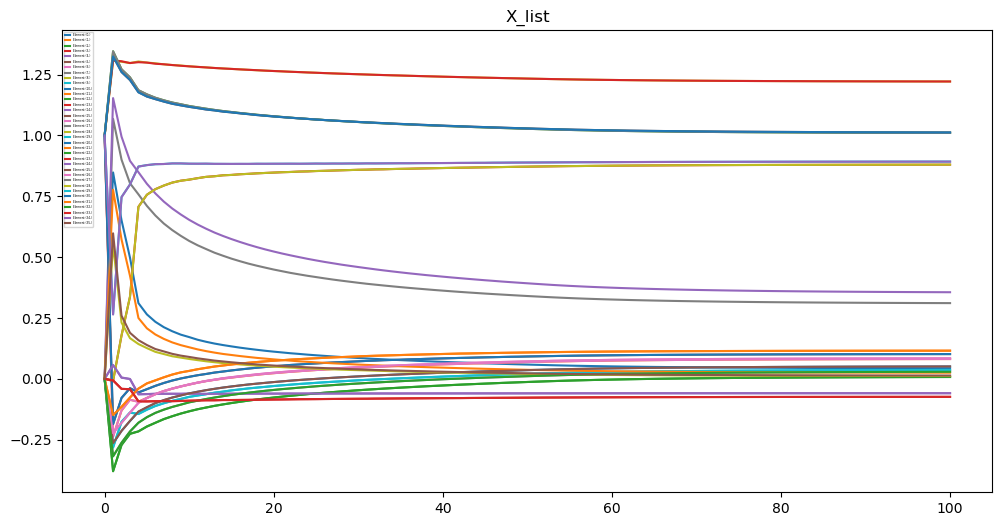

 60%|██████    | 6/10 [01:26<01:03, 15.94s/it]

 - Nombre de différence : 10
 - Somme des différence : 10.0
 - Différence de fonction objective : -38.2 %
Fonction f : 53.347023019148004
Fonction f (arrondi) : 43.86910674313166
Excepted value :  70.99124277022995
X : [[ 0.04  0.08  0.01  0.88 -0.06  1.01]
 [ 0.08  0.31  1.22  0.04  0.05  0.12]
 [ 0.01  1.22  0.36  0.1   0.08  0.03]
 [ 0.88  0.04  0.1   0.03  1.01 -0.07]
 [-0.06  0.05  0.08  1.01  0.01  0.89]
 [ 1.01  0.12  0.03 -0.07  0.89  0.01]]
DELTA : [[ 0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.]
 [ 1.  0. -1.  0.  0. -0.]
 [-1.  0.  0.  0.  0.  1.]
 [ 0. -1.  0. -0.  1.  0.]]
Fonction h : [[0.37721113]
 [0.37882643]]
Gamma : [[30.52624606]
 [20.78087074]]
Rho : 0.0426287951671541
Fonction L : 16067.753552521383


100%|██████████| 100/100 [00:06<00:00, 14.71it/s]


##### FIN !!! / DISTANCE = 0.00031225972715010706 / EPSILON = 0.0005920529220333994 ###


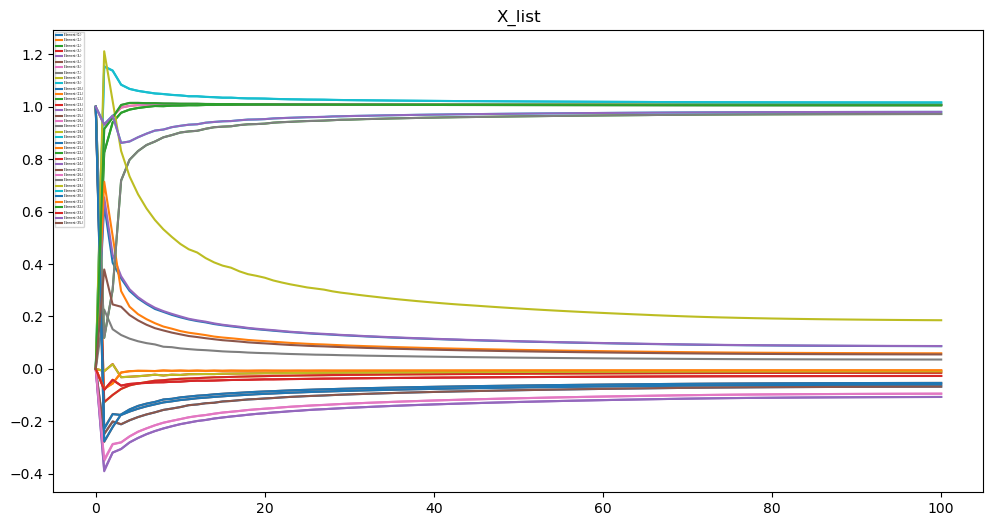

 70%|███████   | 7/10 [01:34<00:39, 13.17s/it]

 - Nombre de différence : 0
 - Somme des différence : 0.0
 - Différence de fonction objective : 0.0 %
Fonction f : 46.24014519533357
Fonction f (arrondi) : 53.77236133698003
Excepted value :  53.77236133698003
X : [[ 0.09  1.01  1.01 -0.01 -0.11 -0.05]
 [ 1.01  0.04 -0.02  1.02 -0.07 -0.01]
 [ 1.01 -0.02  0.09 -0.06 -0.1   1.01]
 [-0.01  1.02 -0.06  0.06  0.97 -0.03]
 [-0.11 -0.07 -0.1   0.97  0.19  0.98]
 [-0.05 -0.01  1.01 -0.03  0.98  0.05]]
DELTA : [[ 0.  0.  0. -0. -0. -0.]
 [ 0.  0. -0.  0. -0. -0.]
 [ 0. -0.  0. -0. -0.  0.]
 [-0.  0. -0.  0.  0. -0.]
 [-0. -0. -0.  0.  0.  0.]
 [-0. -0.  0. -0.  0.  0.]]
Fonction h : [[0.12337695]
 [0.12308024]]
Gamma : [[16.65409206]
 [13.97462763]]
Rho : 0.0968557422292504
Fonction L : 2489.9800960382527


100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


##### FIN !!! / DISTANCE = 0.00032695347345199663 / EPSILON = 0.0005920529220333994 ###


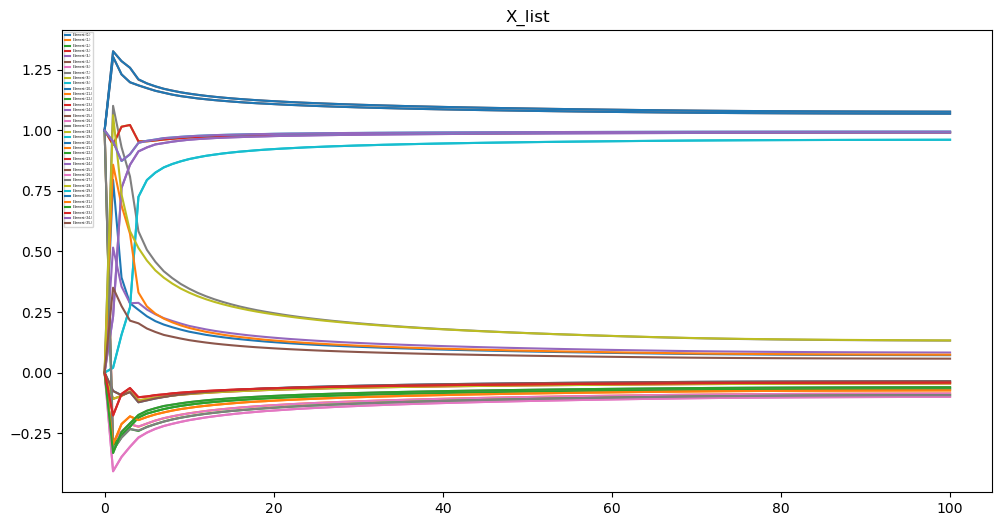

 80%|████████  | 8/10 [01:48<00:26, 13.47s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -5.53 %
Fonction f : 50.909934096981246
Fonction f (arrondi) : 63.27938088432929
Excepted value :  66.98317691373622
X : [[ 0.07 -0.09 -0.07 -0.04  0.99  1.07]
 [-0.09  0.13  0.99  0.96 -0.04 -0.07]
 [-0.07  0.99  0.08  1.08 -0.1  -0.06]
 [-0.04  0.96  1.08  0.07 -0.09 -0.04]
 [ 0.99 -0.04 -0.1  -0.09  0.13  1.  ]
 [ 1.07 -0.07 -0.06 -0.04  1.    0.06]]
DELTA : [[ 0. -0. -0. -0.  0.  0.]
 [-0.  0.  0.  1. -1. -0.]
 [-0.  0.  0.  0. -0. -0.]
 [-0.  1.  0.  0. -0. -1.]
 [ 0. -1. -0. -0.  0.  1.]
 [ 0. -0. -0. -1.  1.  0.]]
Fonction h : [[0.13895805]
 [0.1759548 ]]
Gamma : [[18.96699188]
 [19.73913321]]
Rho : 0.09201295511778788
Fonction L : 4129.165898251372


100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


##### FIN !!! / DISTANCE = 0.00040858510649856105 / EPSILON = 0.0005920529220333994 ###


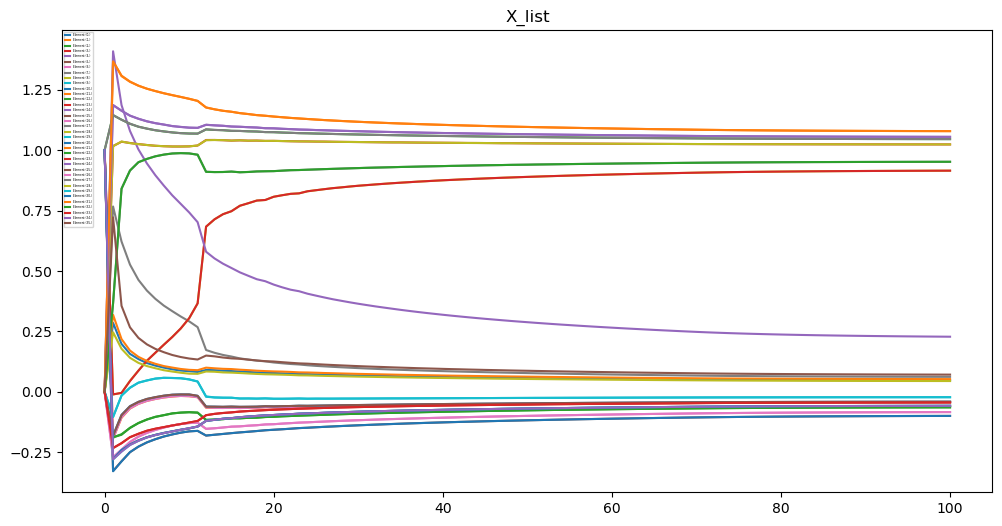

 90%|█████████ | 9/10 [02:04<00:14, 14.20s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -7.21 %
Fonction f : 45.55878640307939
Fonction f (arrondi) : 57.28828059136749
Excepted value :  61.7390095446669
X : [[ 0.05 -0.04 -0.06  1.02  1.05 -0.06]
 [-0.04  0.06  0.92 -0.02 -0.04  1.08]
 [-0.06  0.92  0.23 -0.1  -0.08  0.95]
 [ 1.02 -0.02 -0.1   0.05  1.05 -0.04]
 [ 1.05 -0.04 -0.08  1.05  0.04 -0.06]
 [-0.06  1.08  0.95 -0.04 -0.06  0.07]]
DELTA : [[ 0. -0. -1.  1.  0. -0.]
 [-0.  0.  1. -1. -0.  0.]
 [-1.  1.  0. -0. -0.  0.]
 [ 1. -1. -0.  0.  0. -0.]
 [ 0. -0. -0.  0.  0. -0.]
 [-0.  0.  0. -0. -0.  0.]]
Fonction h : [[0.13753293]
 [0.16662873]]
Gamma : [[21.53905755]
 [17.88019448]]
Rho : 0.10195341287289517
Fonction L : 3894.59320305233


100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


##### FIN !!! / DISTANCE = 0.0003461038653715003 / EPSILON = 0.0005920529220333994 ###


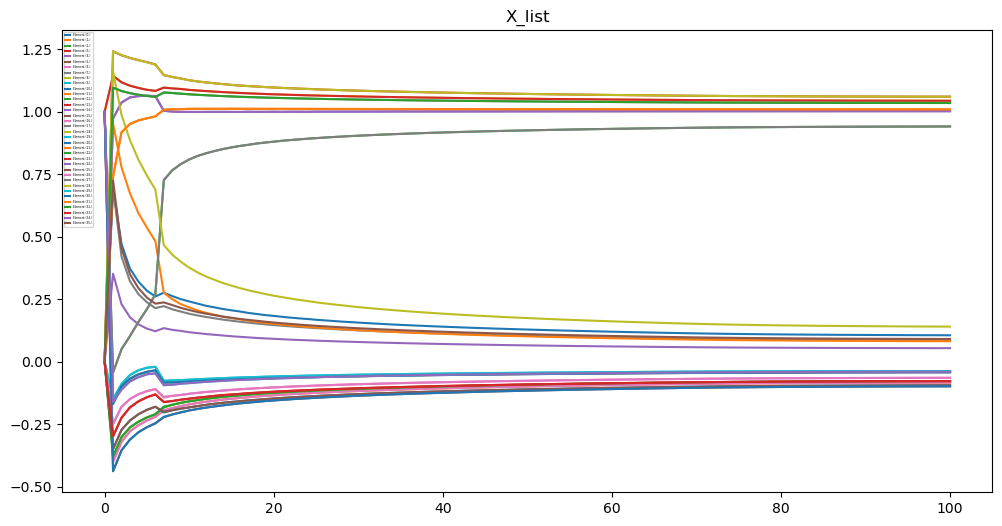

100%|██████████| 10/10 [02:17<00:00, 13.72s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -5.47 %
Fonction f : 53.033693052997435
Fonction f (arrondi) : 65.48867759667402
Excepted value :  69.2776278373376
X : [[ 0.11 -0.08 -0.08  1.06  1.   -0.1 ]
 [-0.08  0.09  1.04 -0.04 -0.09  1.01]
 [-0.08  1.04  0.05 -0.04 -0.06  1.04]
 [ 1.06 -0.04 -0.04  0.08  0.94 -0.08]
 [ 1.   -0.09 -0.06  0.94  0.14 -0.04]
 [-0.1   1.01  1.04 -0.08 -0.04  0.09]]
DELTA : [[ 0. -0. -0.  0.  0. -0.]
 [-0.  0.  0. -1. -0.  1.]
 [-0.  0.  0. -0. -0.  0.]
 [ 0. -1. -0.  0.  1. -0.]
 [ 0. -0. -0.  1.  0. -1.]
 [-0.  1.  0. -0. -1.  0.]]
Fonction h : [[0.13828371]
 [0.1753663 ]]
Gamma : [[19.55416573]
 [19.73058976]]
Rho : 0.0968557422292504
Fonction L : 4042.761495796485
  - Mean : 4.9146069601020965 %
  - Std : 0.060286775853035254 %
  - Min : 4.748255500858424 %
  - Max : 4.965987637959182 %
  - List : [4.88296132680507, 4.913726076204391, 4.965987637959182, 4.936745483336363, 4.939390658412839, 4.74825550

In [7]:
# On peut évaluer les simulations sur plusieurs instances 

# une seule instance (0.1% * 1000 = 1), rounded -> Le résultat est un pourcentage entre gurobi et le solveur RALM
print(a_run(size=6, mute_opt=False, ratio=0.1, rounded=True))

# 10 instances, not rounded -> Le résultat est la norme de frobenus entre gurobi et le solveur RALM
print(a_run(size=6, mute_opt=False, ratio=1.0, rounded=False))

100%|██████████| 20/20 [04:39<00:00, 13.98s/it]


0.1 : 4.939130809581026


100%|██████████| 20/20 [06:07<00:00, 18.40s/it]


0.16681005372000587 : 4.9282297967589965


100%|██████████| 20/20 [04:37<00:00, 13.87s/it]


0.2782559402207124 : 4.92411990383352


100%|██████████| 20/20 [03:48<00:00, 11.41s/it]


0.46415888336127786 : 4.913448208145362


100%|██████████| 20/20 [03:51<00:00, 11.59s/it]


0.774263682681127 : 4.905920829138431


100%|██████████| 20/20 [03:39<00:00, 11.00s/it]


1.291549665014884 : 4.899288748402626


100%|██████████| 20/20 [03:06<00:00,  9.32s/it]


2.1544346900318834 : 4.893434079332205


100%|██████████| 20/20 [02:34<00:00,  7.73s/it]


3.593813663804626 : 4.888028322630049


100%|██████████| 20/20 [02:00<00:00,  6.01s/it]


5.994842503189409 : 4.882931676499446


100%|██████████| 20/20 [01:48<00:00,  5.42s/it]

10.0 : 4.828910805398392


[]

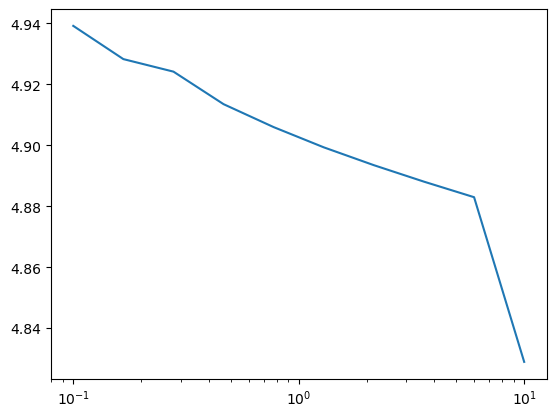

In [8]:
# On peut analyser un paramètre sur un intervale (échelle log10)

# Borne inférieur (puissance 10)
borne_inf = -1
# Borne supérieur (puissance 10)
borne_sup = 1

# On réaliser un graphe pour Rho_var (échelle log), avec 20 instances de taille 6
val = []
ord = []
for i in np.logspace(borne_inf, borne_sup, 10):
    ord += [i]
    r = a_run(size=6, mute_opt=True, ratio=2, rounded=False, Rho_var=i, mute_stat=True)
    val += [r]
    print(i, ":", r)
plt.plot(ord, val)
plt.xscale("log")
plt.plot()

# On peut alors regarder les zones non pertinentes pour un paramètres (indépendament des autres)

100%|██████████| 100/100 [00:09<00:00, 11.02it/s]


##### FIN !!! / DISTANCE = 0.00034529648219744737 / EPSILON = 0.0005920529220333994 ###


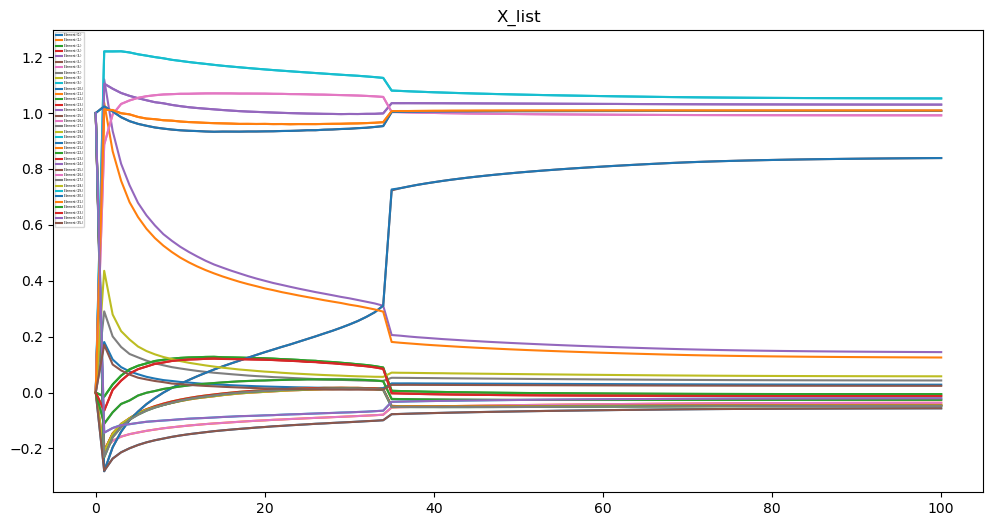

 10%|█         | 1/10 [00:09<01:25,  9.50s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : 1.97 %
Fonction f : 38.733729148996346
Fonction f (arrondi) : 44.15628502508495
Excepted value :  43.30372961038708
X : [[ 0.03 -0.04 -0.01 -0.05  1.03  1.01]
 [-0.04  0.04 -0.05  1.05 -0.06  1.01]
 [-0.01 -0.05  0.14  0.84  0.99 -0.03]
 [-0.05  1.05  0.84  0.13 -0.05 -0.01]
 [ 1.03 -0.06  0.99 -0.05  0.06 -0.02]
 [ 1.01  1.01 -0.03 -0.01 -0.02  0.02]]
DELTA : [[ 0. -0. -0. -0.  0.  0.]
 [-0.  0. -1.  0. -0.  1.]
 [-0. -1.  0.  1.  0. -0.]
 [-0.  0.  1.  0. -0. -1.]
 [ 0. -0.  0. -0.  0. -0.]
 [ 0.  1. -0. -1. -0.  0.]]
Fonction h : [[0.08860576]
 [0.1050738 ]]
Gamma : [[17.76456578]
 [11.97412111]]
Rho : 0.09201295511778788
Fonction L : 2535.5600346634633


100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


##### FIN !!! / DISTANCE = 0.00033323874265951713 / EPSILON = 0.0005920529220333994 ###


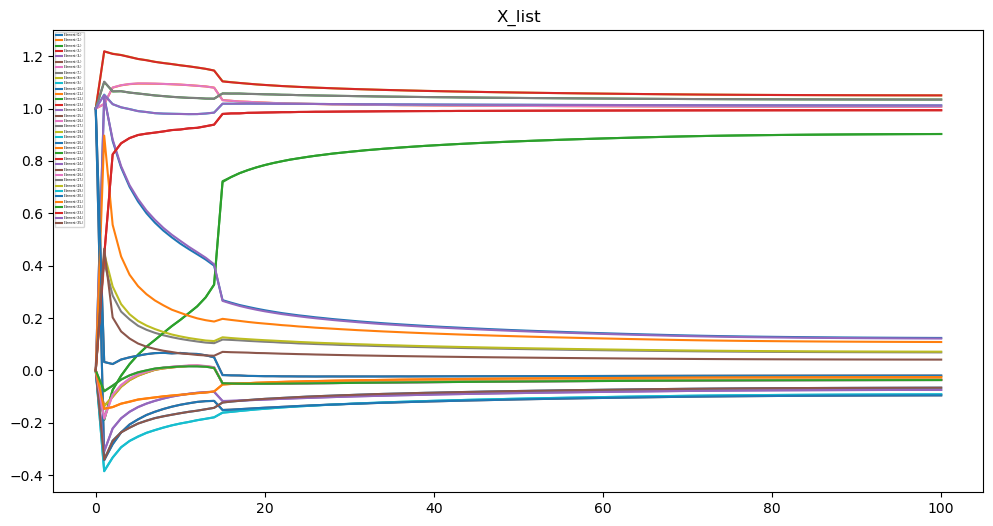

 20%|██        | 2/10 [00:17<01:10,  8.84s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -0.28 %
Fonction f : 53.12202803021385
Fonction f (arrondi) : 62.028801819653566
Excepted value :  62.2050522125665
X : [[ 0.12  1.01  0.9  -0.03 -0.07 -0.02]
 [ 1.01  0.07  1.05 -0.09 -0.07 -0.03]
 [ 0.9   1.05  0.12 -0.1  -0.04 -0.04]
 [-0.03 -0.09 -0.1   0.11  1.03  0.99]
 [-0.07 -0.07 -0.04  1.03  0.07  1.01]
 [-0.02 -0.03 -0.04  0.99  1.01  0.04]]
DELTA : [[ 0.  0.  1. -1. -0. -0.]
 [ 0.  0.  0. -0. -0. -0.]
 [ 1.  0.  0. -0. -0. -1.]
 [-1. -0. -0.  0.  0.  1.]
 [-0. -0. -0.  0.  0.  0.]
 [-0. -0. -1.  1.  0.  0.]]
Fonction h : [[0.12007434]
 [0.14162415]]
Gamma : [[18.86046224]
 [15.56283336]]
Rho : 0.0968557422292504
Fonction L : 3144.2386323357377


100%|██████████| 100/100 [00:04<00:00, 21.71it/s]


##### FIN !!! / DISTANCE = 0.0003086860965169981 / EPSILON = 0.0005920529220333994 ###


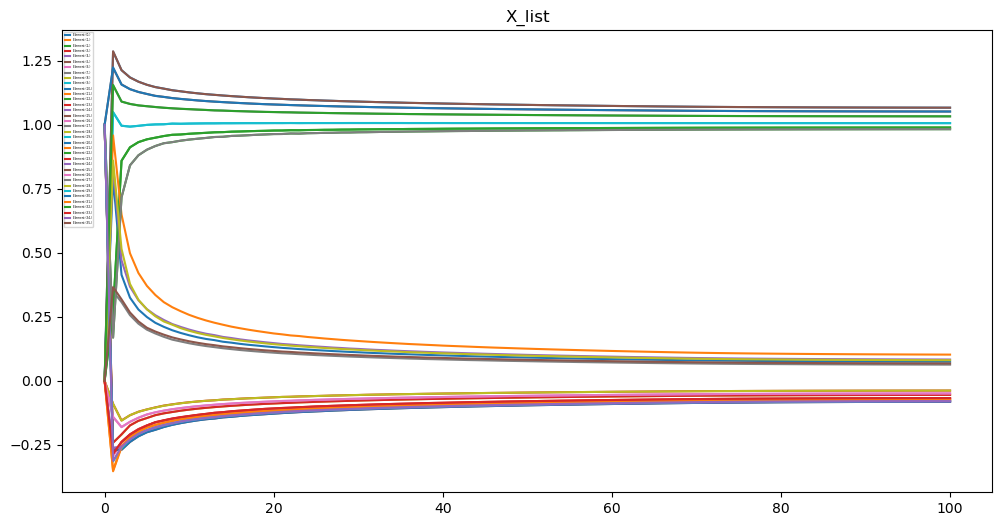

 30%|███       | 3/10 [00:22<00:49,  7.07s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -10.71 %
Fonction f : 32.38836517449893
Fonction f (arrondi) : 40.4523512354909
Excepted value :  45.302933761996194
X : [[ 0.07 -0.07  0.99 -0.04 -0.08  1.05]
 [-0.07  0.06 -0.05  1.01  1.07 -0.07]
 [ 0.99 -0.05  0.08 -0.08 -0.05  1.03]
 [-0.04  1.01 -0.08  0.1   0.98 -0.07]
 [-0.08  1.07 -0.05  0.98  0.08 -0.08]
 [ 1.05 -0.07  1.03 -0.07 -0.08  0.07]]
DELTA : [[ 0. -0.  1. -1. -0.  0.]
 [-0.  0. -0.  0.  0. -0.]
 [ 1. -0.  0. -0. -1.  0.]
 [-1.  0. -0.  0.  1. -0.]
 [-0.  0. -1.  1.  0. -0.]
 [ 0. -0.  0. -0. -0.  0.]]
Fonction h : [[0.10793442]
 [0.14582498]]
Gamma : [[14.07583352]
 [16.72614754]]
Rho : 0.09201295511778788
Fonction L : 2633.2276661544925


100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


##### FIN !!! / DISTANCE = 0.0002787990293001533 / EPSILON = 0.0005920529220333994 ###


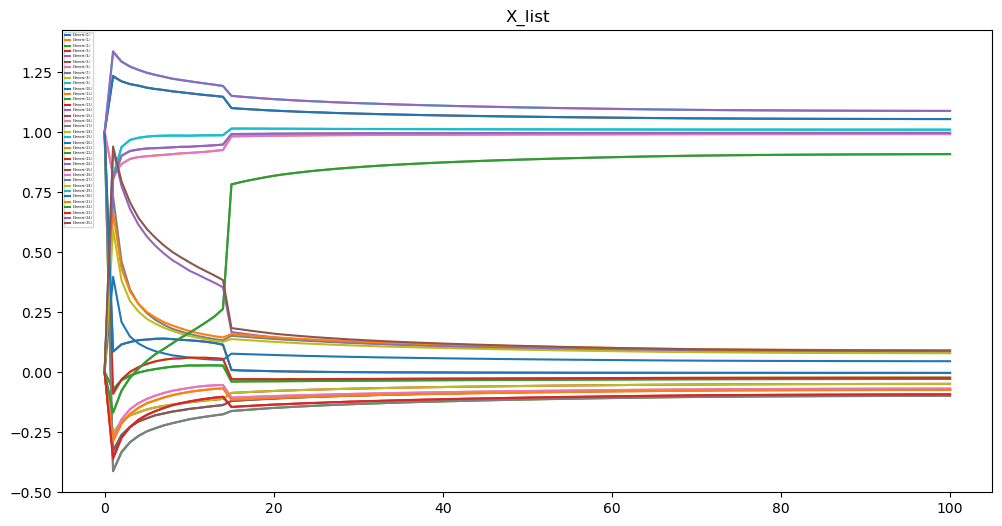

 40%|████      | 4/10 [00:30<00:43,  7.28s/it]

 - Nombre de différence : 0
 - Somme des différence : 0.0
 - Différence de fonction objective : 0.0 %
Fonction f : 38.64281234040169
Fonction f (arrondi) : 47.678905607466994
Excepted value :  47.678905607466994
X : [[ 0.05  0.99 -0.03 -0.05  1.   -0.  ]
 [ 0.99  0.09 -0.02  1.01 -0.07 -0.07]
 [-0.03 -0.02  0.08  1.06 -0.07  0.91]
 [-0.05  1.01  1.06  0.09 -0.1  -0.09]
 [ 1.   -0.07 -0.07 -0.1   0.08  1.09]
 [-0.   -0.07  0.91 -0.09  1.09  0.09]]
DELTA : [[ 0.  0. -0. -0.  0. -0.]
 [ 0.  0. -0.  0. -0. -0.]
 [-0. -0.  0.  0. -0.  0.]
 [-0.  0.  0.  0. -0. -0.]
 [ 0. -0. -0. -0.  0.  0.]
 [-0. -0.  0. -0.  0.  0.]]
Fonction h : [[0.10367035]
 [0.15922497]]
Gamma : [[15.98838269]
 [17.51678767]]
Rho : 0.07888960739411338
Fonction L : 3607.9852164952454


100%|██████████| 100/100 [00:07<00:00, 13.96it/s]


##### FIN !!! / DISTANCE = 0.00032572294645136175 / EPSILON = 0.0005920529220333994 ###


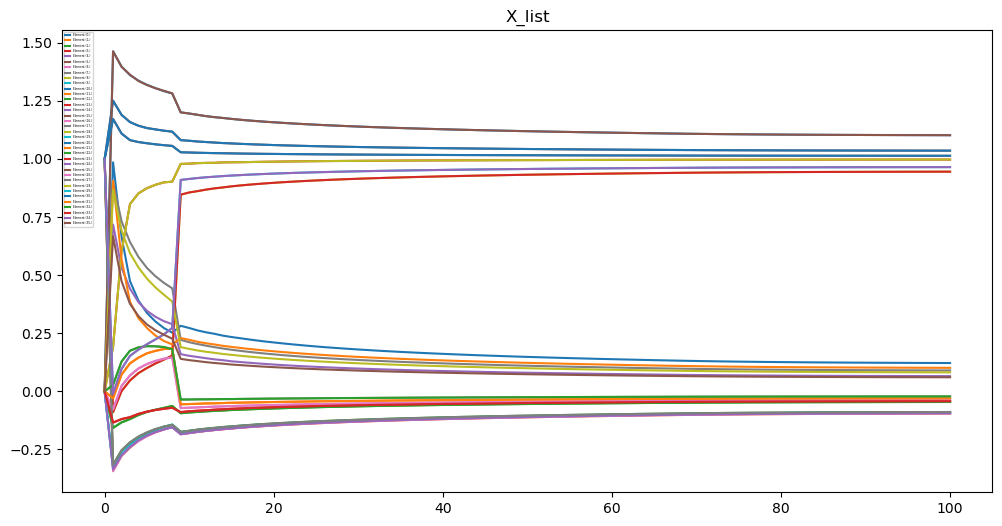

 50%|█████     | 5/10 [00:38<00:36,  7.39s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : 0.12 %
Fonction f : 47.72865904483649
Fonction f (arrondi) : 59.05264071476323
Excepted value :  58.98436016441066
X : [[ 0.12 -0.1  -0.05  1.   -0.09  1.01]
 [-0.1   0.09  0.95 -0.09  1.1  -0.03]
 [-0.05  0.95  0.07  1.04 -0.04 -0.02]
 [ 1.   -0.09  1.04  0.1  -0.09 -0.04]
 [-0.09  1.1  -0.04 -0.09  0.08  0.96]
 [ 1.01 -0.03 -0.02 -0.04  0.96  0.06]]
DELTA : [[ 0. -0. -0.  0. -0.  0.]
 [-0.  0.  1. -0.  0. -1.]
 [-0.  1.  0.  0. -1. -0.]
 [ 0. -0.  0.  0. -0. -0.]
 [-0.  0. -1. -0.  0.  1.]
 [ 0. -1. -0. -0.  1.  0.]]
Fonction h : [[0.12274885]
 [0.17194377]]
Gamma : [[18.13653165]
 [19.3642059 ]]
Rho : 0.0968557422292504
Fonction L : 3687.0734912443113


100%|██████████| 100/100 [00:11<00:00,  8.80it/s]


##### FIN !!! / DISTANCE = 0.00030614816746171443 / EPSILON = 0.0005920529220333994 ###


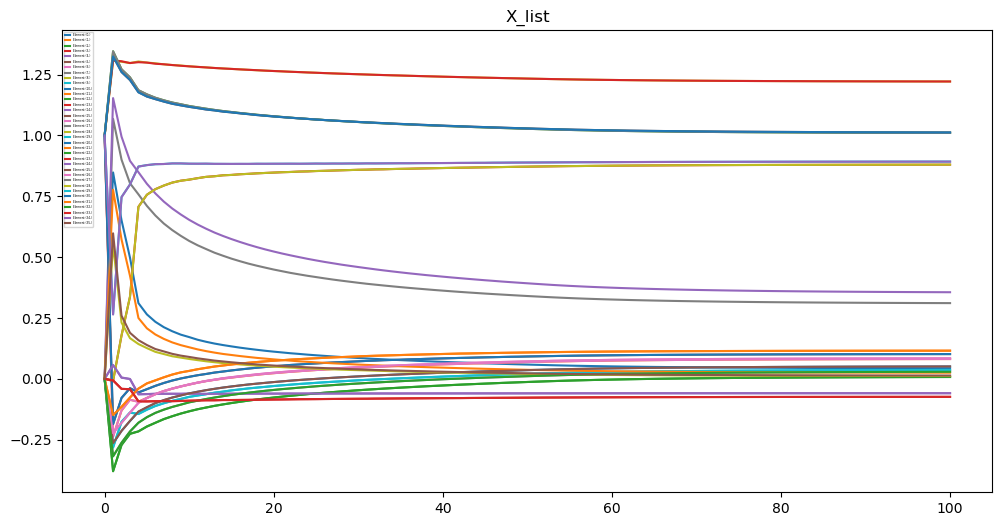

 60%|██████    | 6/10 [00:49<00:35,  8.87s/it]

 - Nombre de différence : 10
 - Somme des différence : 10.0
 - Différence de fonction objective : -38.2 %
Fonction f : 53.347023019148004
Fonction f (arrondi) : 43.86910674313166
Excepted value :  70.99124277022995
X : [[ 0.04  0.08  0.01  0.88 -0.06  1.01]
 [ 0.08  0.31  1.22  0.04  0.05  0.12]
 [ 0.01  1.22  0.36  0.1   0.08  0.03]
 [ 0.88  0.04  0.1   0.03  1.01 -0.07]
 [-0.06  0.05  0.08  1.01  0.01  0.89]
 [ 1.01  0.12  0.03 -0.07  0.89  0.01]]
DELTA : [[ 0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.]
 [ 1.  0. -1.  0.  0. -0.]
 [-1.  0.  0.  0.  0.  1.]
 [ 0. -1.  0. -0.  1.  0.]]
Fonction h : [[0.37721113]
 [0.37882643]]
Gamma : [[30.52624606]
 [20.78087074]]
Rho : 0.0426287951671541
Fonction L : 16067.753552521383


100%|██████████| 100/100 [00:03<00:00, 31.64it/s]


##### FIN !!! / DISTANCE = 0.00031225972715010706 / EPSILON = 0.0005920529220333994 ###


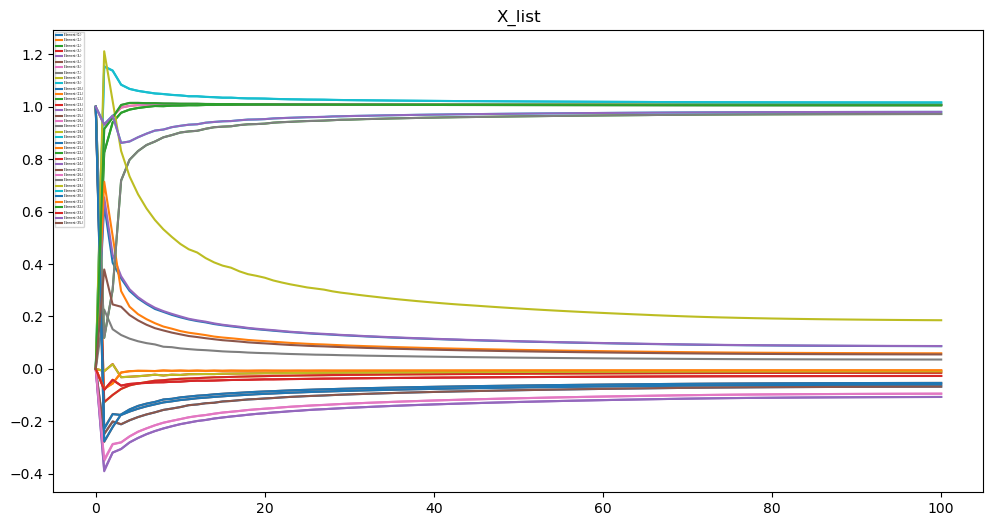

 70%|███████   | 7/10 [00:53<00:21,  7.14s/it]

 - Nombre de différence : 0
 - Somme des différence : 0.0
 - Différence de fonction objective : 0.0 %
Fonction f : 46.24014519533357
Fonction f (arrondi) : 53.77236133698003
Excepted value :  53.77236133698003
X : [[ 0.09  1.01  1.01 -0.01 -0.11 -0.05]
 [ 1.01  0.04 -0.02  1.02 -0.07 -0.01]
 [ 1.01 -0.02  0.09 -0.06 -0.1   1.01]
 [-0.01  1.02 -0.06  0.06  0.97 -0.03]
 [-0.11 -0.07 -0.1   0.97  0.19  0.98]
 [-0.05 -0.01  1.01 -0.03  0.98  0.05]]
DELTA : [[ 0.  0.  0. -0. -0. -0.]
 [ 0.  0. -0.  0. -0. -0.]
 [ 0. -0.  0. -0. -0.  0.]
 [-0.  0. -0.  0.  0. -0.]
 [-0. -0. -0.  0.  0.  0.]
 [-0. -0.  0. -0.  0.  0.]]
Fonction h : [[0.12337695]
 [0.12308024]]
Gamma : [[16.65409206]
 [13.97462763]]
Rho : 0.0968557422292504
Fonction L : 2489.9800960382527


100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


##### FIN !!! / DISTANCE = 0.00032695347345199663 / EPSILON = 0.0005920529220333994 ###


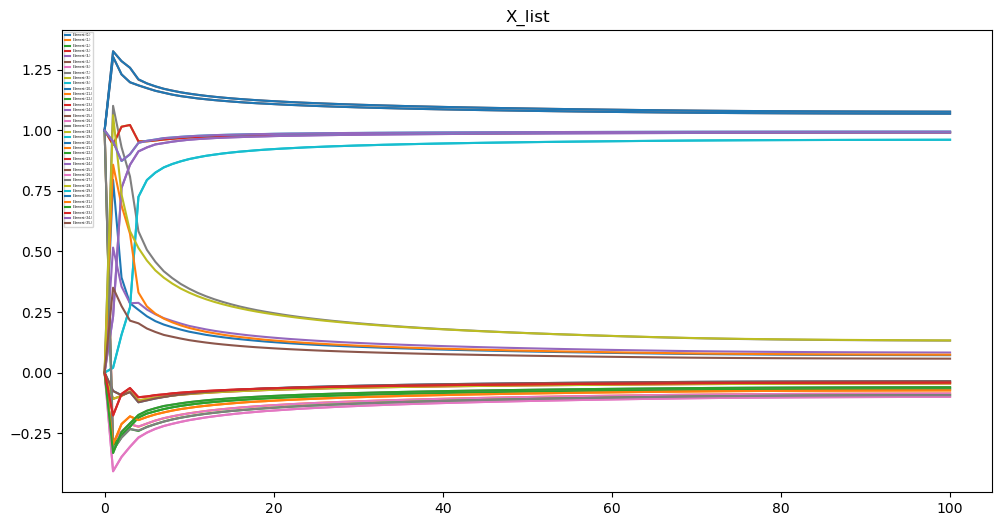

 80%|████████  | 8/10 [01:01<00:14,  7.44s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -5.53 %
Fonction f : 50.909934096981246
Fonction f (arrondi) : 63.27938088432929
Excepted value :  66.98317691373622
X : [[ 0.07 -0.09 -0.07 -0.04  0.99  1.07]
 [-0.09  0.13  0.99  0.96 -0.04 -0.07]
 [-0.07  0.99  0.08  1.08 -0.1  -0.06]
 [-0.04  0.96  1.08  0.07 -0.09 -0.04]
 [ 0.99 -0.04 -0.1  -0.09  0.13  1.  ]
 [ 1.07 -0.07 -0.06 -0.04  1.    0.06]]
DELTA : [[ 0. -0. -0. -0.  0.  0.]
 [-0.  0.  0.  1. -1. -0.]
 [-0.  0.  0.  0. -0. -0.]
 [-0.  1.  0.  0. -0. -1.]
 [ 0. -1. -0. -0.  0.  1.]
 [ 0. -0. -0. -1.  1.  0.]]
Fonction h : [[0.13895805]
 [0.1759548 ]]
Gamma : [[18.96699188]
 [19.73913321]]
Rho : 0.09201295511778788
Fonction L : 4129.165898251372


100%|██████████| 100/100 [00:09<00:00, 10.66it/s]


##### FIN !!! / DISTANCE = 0.00040858510649856105 / EPSILON = 0.0005920529220333994 ###


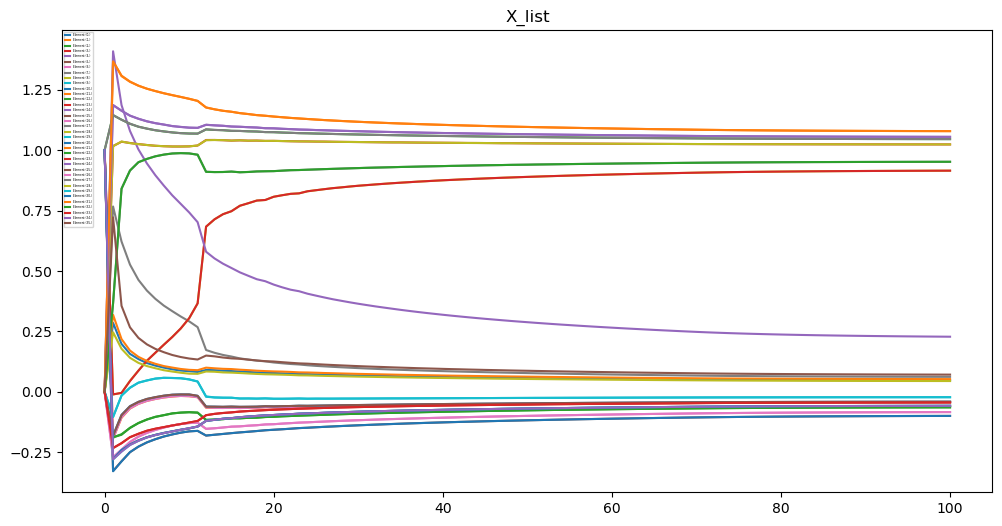

 90%|█████████ | 9/10 [01:11<00:08,  8.17s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -7.21 %
Fonction f : 45.55878640307939
Fonction f (arrondi) : 57.28828059136749
Excepted value :  61.7390095446669
X : [[ 0.05 -0.04 -0.06  1.02  1.05 -0.06]
 [-0.04  0.06  0.92 -0.02 -0.04  1.08]
 [-0.06  0.92  0.23 -0.1  -0.08  0.95]
 [ 1.02 -0.02 -0.1   0.05  1.05 -0.04]
 [ 1.05 -0.04 -0.08  1.05  0.04 -0.06]
 [-0.06  1.08  0.95 -0.04 -0.06  0.07]]
DELTA : [[ 0. -0. -1.  1.  0. -0.]
 [-0.  0.  1. -1. -0.  0.]
 [-1.  1.  0. -0. -0.  0.]
 [ 1. -1. -0.  0.  0. -0.]
 [ 0. -0. -0.  0.  0. -0.]
 [-0.  0.  0. -0. -0.  0.]]
Fonction h : [[0.13753293]
 [0.16662873]]
Gamma : [[21.53905755]
 [17.88019448]]
Rho : 0.10195341287289517
Fonction L : 3894.59320305233


100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


##### FIN !!! / DISTANCE = 0.0003461038653715003 / EPSILON = 0.0005920529220333994 ###


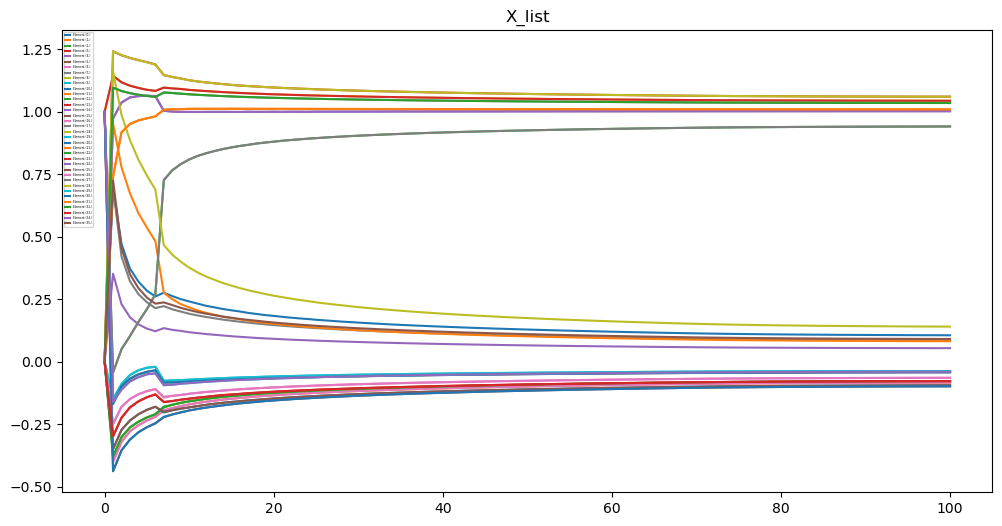

100%|██████████| 10/10 [01:21<00:00,  8.12s/it]

 - Nombre de différence : 8
 - Somme des différence : 8.0
 - Différence de fonction objective : -5.47 %
Fonction f : 53.033693052997435
Fonction f (arrondi) : 65.48867759667402
Excepted value :  69.2776278373376
X : [[ 0.11 -0.08 -0.08  1.06  1.   -0.1 ]
 [-0.08  0.09  1.04 -0.04 -0.09  1.01]
 [-0.08  1.04  0.05 -0.04 -0.06  1.04]
 [ 1.06 -0.04 -0.04  0.08  0.94 -0.08]
 [ 1.   -0.09 -0.06  0.94  0.14 -0.04]
 [-0.1   1.01  1.04 -0.08 -0.04  0.09]]
DELTA : [[ 0. -0. -0.  0.  0. -0.]
 [-0.  0.  0. -1. -0.  1.]
 [-0.  0.  0. -0. -0.  0.]
 [ 0. -1. -0.  0.  1. -0.]
 [ 0. -0. -0.  1.  0. -1.]
 [-0.  1.  0. -0. -1.  0.]]
Fonction h : [[0.13828371]
 [0.1753663 ]]
Gamma : [[19.55416573]
 [19.73058976]]
Rho : 0.0968557422292504
Fonction L : 4042.761495796485
  - Mean : 4.9146069601020965 %
  - Std : 0.060286775853035254 %
  - Min : 4.748255500858424 %
  - Max : 4.965987637959182 %
  - List : [4.88296132680507, 4.913726076204391, 4.965987637959182, 4.936745483336363, 4.939390658412839, 4.74825550

In [9]:
print(a_run(size=6, ratio=1, rounded=False, mute_opt=False, mute_run=False))

 90%|████████▉ | 179/200 [00:14<00:01, 12.37it/s] 


##### FIN !!! / DISTANCE = 0.0 / EPSILON = 1e-05 ###


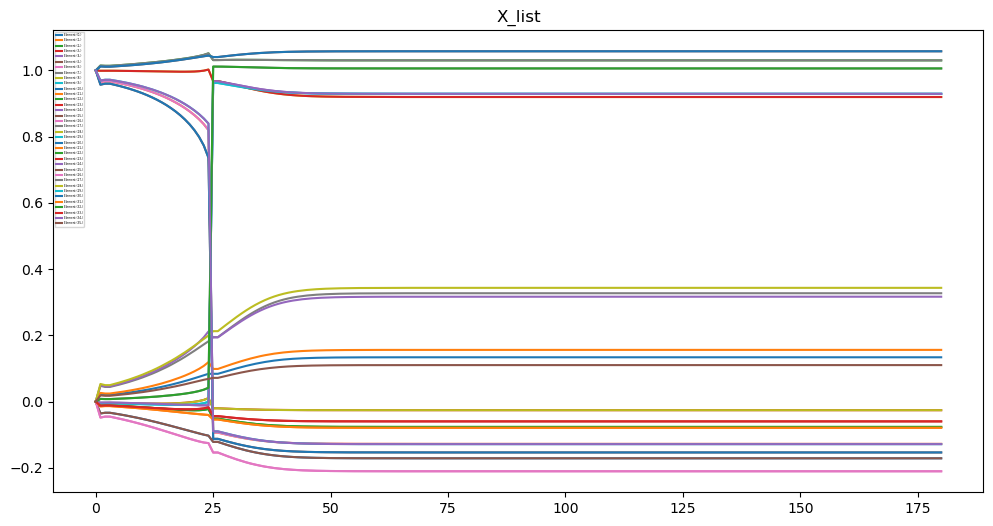

 - Nombre de différence : 0
 - Somme des différence : 0.0
 - Différence de fonction objective : 0.0 %
Fonction f : 257.2947355082539
Fonction f (arrondi) : 386.3661946462156
Excepted value :  386.3661946462156
X : [[ 0.13 -0.13 -0.08 -0.03  0.93  1.06]
 [-0.13  0.33  0.92  0.93 -0.17 -0.08]
 [-0.08  0.92  0.32 -0.15 -0.21  1.01]
 [-0.03  0.93 -0.15  0.16  1.03 -0.06]
 [ 0.93 -0.17 -0.21  1.03  0.34 -0.13]
 [ 1.06 -0.08  1.01 -0.06 -0.13  0.11]]
DELTA : [[ 0. -0. -0. -0.  0.  0.]
 [-0.  0.  0.  0. -0. -0.]
 [-0.  0.  0. -0. -0.  0.]
 [-0.  0. -0.  0.  0. -0.]
 [ 0. -0. -0.  0.  0. -0.]
 [ 0. -0.  0. -0. -0.  0.]]
Fonction h : [[0.69711098]
 [0.61894461]]
Gamma : [[50.]
 [50.]]
Rho : 7.029552803973818e-14
Fonction L : 3.556413999176119e+16
Avec param (6) (0, 0.0, 386.3661946462156, 386.3661946462156, 181, 4.920202386724249)


In [10]:
print("Avec param (6)", the_big_solver(P_1, n_iter=200, Rho_var=10000, Theta_rho=0.80, Var_gamma_max=50))